In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns 
sns.set()
%matplotlib inline
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import seaborn as sns
sns.set()
pd.options.mode.chained_assignment = None  # default='warn'

from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Read in the cleansed and winsorised data
df = pd.read_csv(r"C:\Users\krist\Documents\Data\ger_factor_data_from2003.csv", dtype ={"comp_tpci": str}, parse_dates =["eom"])
#Convert to float 32 (format needed for the most ML models)
df[df.columns[2:]] = df[df.columns[2:]].astype('float32')
#Sort observations by date and stock id
df = df.sort_values(by = ['eom', 'id'], ascending = True)
df.head()

,id,eom,prc,me,ret,ret_exc,ret_exc_lead1m,ret_6_1,ret_12_1,tax_gr1a,...,cowc_gr1a,pi_nix,ret_6_0,ret_1_0,noa_at,cop_atl1,prc_highprc_252d,ocf_at,dbnetis_at,netdebt_me
0,comp_001166_02W,2003-01-31,11.486148,567.074646,-0.018948,-0.019948,-0.089504,-0.229560,-0.353251,-0.020556,...,0.041844,3.815513,-0.244158,-0.018948,0.692706,0.093015,0.398130,-0.007700,0.085202,0.135368
1,comp_001661_01W,2003-01-31,35.853958,5221.931641,0.005815,0.004815,0.108428,0.129149,-0.035109,-0.033306,...,-0.019596,1.284930,0.135715,0.005815,0.751569,0.164124,0.918059,0.096164,0.063714,0.200036
2,comp_004367_02W,2003-01-31,36.068653,4139.599121,-0.103801,-0.104801,0.127227,-0.020286,0.087151,-0.037240,...,0.026114,1.725004,-0.121981,-0.103801,0.961141,0.240563,0.675468,0.070724,-0.000607,0.410184
3,comp_004925_02W,2003-01-31,29.735168,15302.482422,-0.070425,-0.071425,0.064832,0.046064,0.023265,-0.007344,...,-0.000724,1.961724,-0.027605,-0.070425,0.466852,0.221983,0.861333,0.084234,-0.008142,-0.075232
4,comp_005959_01W,2003-01-31,39.181721,6355.691406,-0.085813,-0.086813,0.001832,0.123795,0.012811,-0.012241,...,-0.014214,1.069862,0.027359,-0.085813,0.635742,0.108581,0.721256,0.069331,-0.038594,0.500641


In [3]:
# The observation period contains 204 months in the period from 01.2003 to 12.2019'
# The last year is not uesed since we dont have the lead excess return  "ret_exc_lead1m" for January 2021 and we
# use 1 year for testing
df_2 = df[~(df['eom'] > '2019-12-31')]
print("Number of months: ", df_2["eom"].nunique())
print("Start: ", df_2["eom"].min())
print("End: ", df_2["eom"].max())

Number of months:  204
Start:  2003-01-31 00:00:00
End:  2019-12-31 00:00:00


In [4]:
#There are 1810 unique german stocks
print("Number of unique stcocks: ", df_2["id"].nunique())

Number of unique stcocks:  1810


In [5]:
#Inspect variable types
df_2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148530 entries, 0 to 148529
Data columns (total 55 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                148530 non-null  object        
 1   eom               148530 non-null  datetime64[ns]
 2   prc               148530 non-null  float32       
 3   me                148530 non-null  float32       
 4   ret               148530 non-null  float32       
 5   ret_exc           148530 non-null  float32       
 6   ret_exc_lead1m    148530 non-null  float32       
 7   ret_6_1           148530 non-null  float32       
 8   ret_12_1          148530 non-null  float32       
 9   tax_gr1a          148530 non-null  float32       
 10  be_me             148530 non-null  float32       
 11  debt_me           148530 non-null  float32       
 12  ni_me             148530 non-null  float32       
 13  sale_gr3          148530 non-null  float32       
 14  sale

Minimum number of stocks pre month:  442
Maximum number of stocks pre month:  853
Mean number of stocks pre month:  728.0882352941177


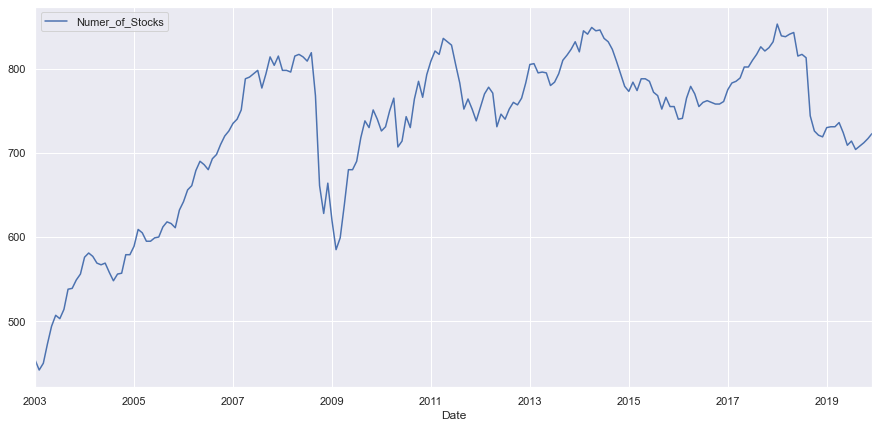

In [6]:
#Number of stocks at each month; 
Number_stocks_per_month = Counter(df_2['eom'])
Number_stocks_per_month= pd.DataFrame(Number_stocks_per_month.items(), columns=['Date', 'Numer_of_Stocks'])
print("Minimum number of stocks pre month: ", Number_stocks_per_month["Numer_of_Stocks"].min())
print("Maximum number of stocks pre month: ", Number_stocks_per_month["Numer_of_Stocks"].max())
print("Mean number of stocks pre month: ", Number_stocks_per_month["Numer_of_Stocks"].mean())
Number_stocks_per_month.plot(x='Date', y='Numer_of_Stocks',grid=True,figsize=(15, 7));


### Descriptive Statistics of the characteristics

In [8]:
#We are interested in the descriptive statistics of all 49 stock level characteristics and the target variable (ret_exc_lead1m)
features = df.columns[~df.columns.isin(['id',"prc","eom","ret","ret_exc"])].tolist()

In [9]:
descriptive_statistics = df_2[features].describe()
descriptive_statistics

,me,ret_exc_lead1m,ret_6_1,ret_12_1,tax_gr1a,be_me,debt_me,ni_me,sale_gr3,sale_gr1,...,cowc_gr1a,pi_nix,ret_6_0,ret_1_0,noa_at,cop_atl1,prc_highprc_252d,ocf_at,dbnetis_at,netdebt_me
count,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,...,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000
mean,8697.302734,0.007087,0.075473,0.177930,0.001510,0.655195,0.652363,0.044014,0.502651,0.149736,...,0.004955,1.541284,0.091800,0.013808,0.528437,0.175243,0.827804,0.073523,0.007110,0.426264
std,21088.613281,0.099301,0.252284,0.442067,0.017356,0.493008,1.483294,0.089383,1.337435,0.462402,...,0.066108,0.836671,0.286495,0.099923,0.269429,0.143578,0.155697,0.095224,0.091258,1.276193
min,28.031742,-0.285795,-0.506119,-0.629095,-0.064525,0.050845,0.000000,-0.397647,-0.770523,-0.618313,...,-0.236067,0.426156,-0.540160,-0.260097,-0.367537,-0.391054,0.302827,-0.305821,-0.305372,-0.893911
25%,145.166351,-0.045686,-0.067556,-0.081281,-0.003849,0.332355,0.060375,0.023869,-0.019904,-0.037324,...,-0.015919,1.243138,-0.072558,-0.040538,0.405554,0.115518,0.755598,0.026326,-0.023001,-0.038982
50%,781.303467,0.004405,0.048987,0.115161,0.000700,0.535195,0.231009,0.048086,0.197949,0.069350,...,0.004122,1.395275,0.059886,0.008779,0.545954,0.166833,0.871676,0.073250,0.000000,0.101810
75%,5733.725708,0.057243,0.186266,0.335885,0.006895,0.828575,0.544563,0.075752,0.521168,0.208702,...,0.026030,1.571180,0.214114,0.061570,0.664305,0.229655,0.944851,0.120141,0.032216,0.382029
max,132047.843750,0.337193,1.077414,2.111902,0.069120,2.902265,10.795302,0.340293,10.089679,3.220137,...,0.250548,7.488226,1.259137,0.371817,1.403841,0.652698,1.000000,0.344624,0.350461,9.083357


In [10]:
descriptive_statistics.to_excel(r'C:\Users\krist\Documents\Data\EDA\descriptive_statistics.xlsx')

### Distribution of each feature

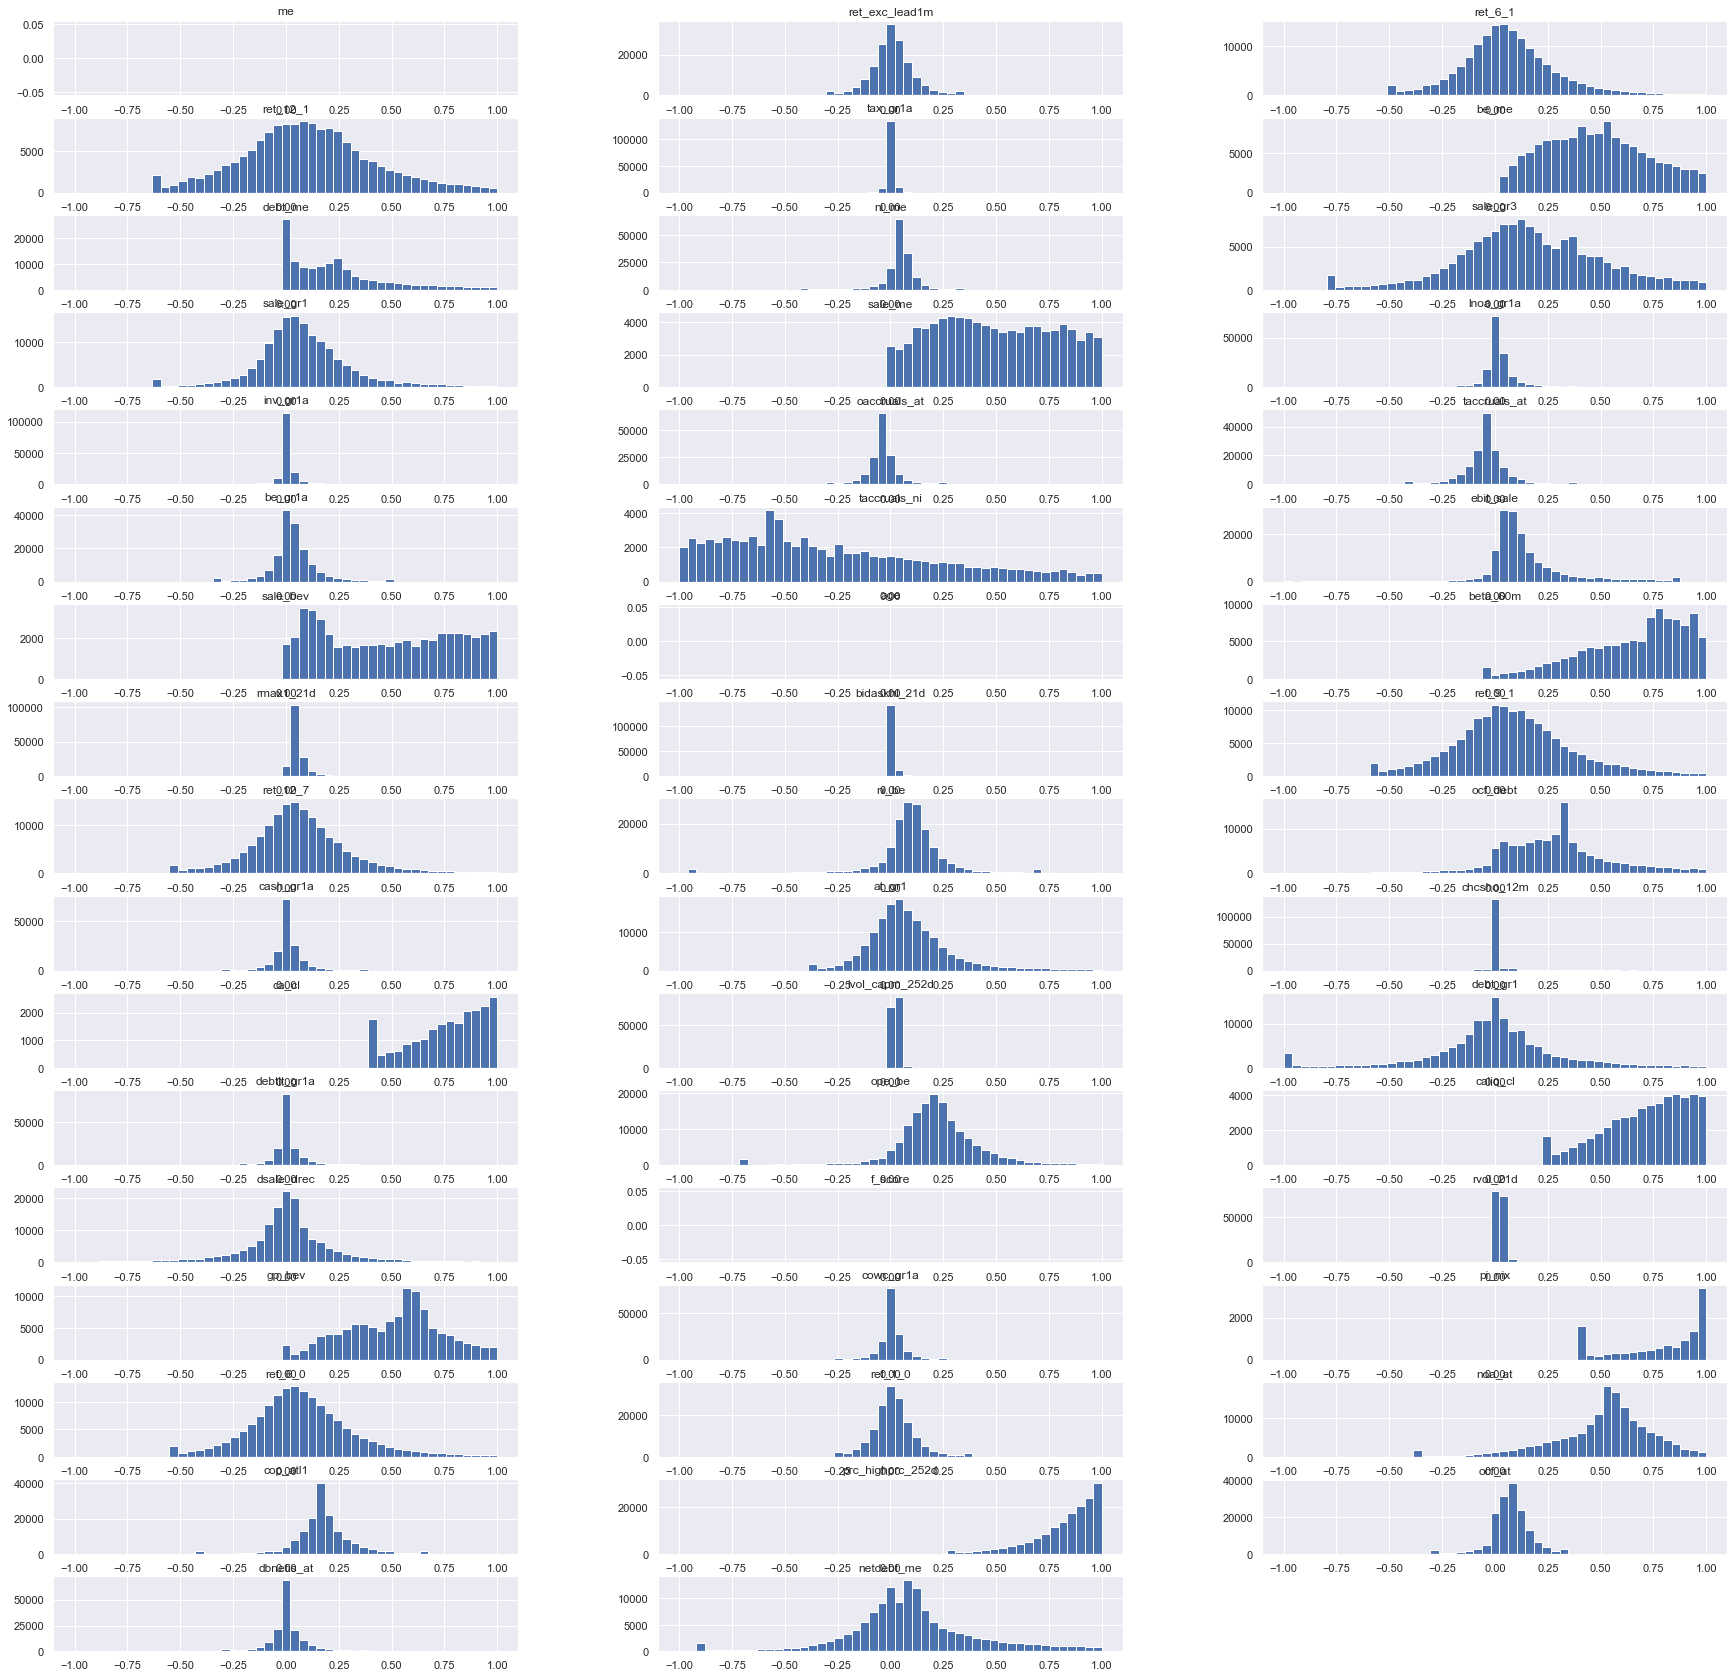

In [11]:
fig, ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(30)
df[features].hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax);

### Distribution of portfolio returns

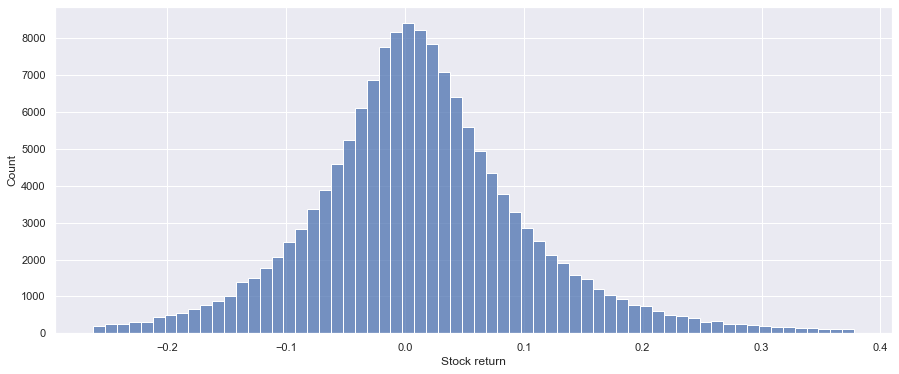

In [114]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
df_3 = df_2[["ret"]]
df_3 = df_3.rename(columns={'ret': 'Stock return'})
sns.histplot(data = df_3, x ="Stock return", binwidth = 0.01, binrange = (df_3["Stock return"].min()+ 0.00000000001, df_3["Stock return"].max()- 0.01))
plt.savefig('returns_distrubution.png')

### Distribution of firm size

<AxesSubplot:xlabel='me', ylabel='Count'>

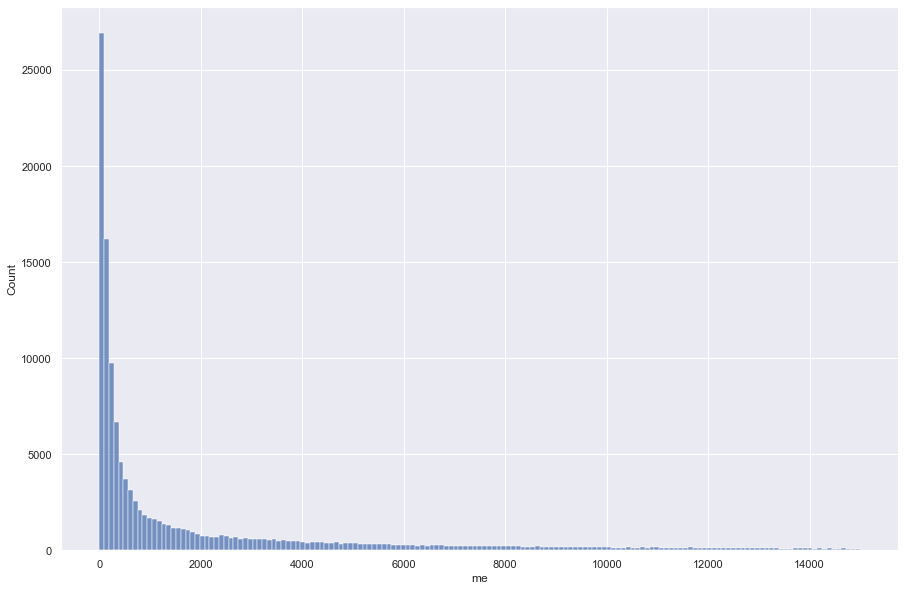

In [89]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10
sns.histplot(data = df_2, x ="me", binrange = (0,15000))
plt.savefig('size_distrubution.png')

### Equally weighted portfolio monthly returns over time

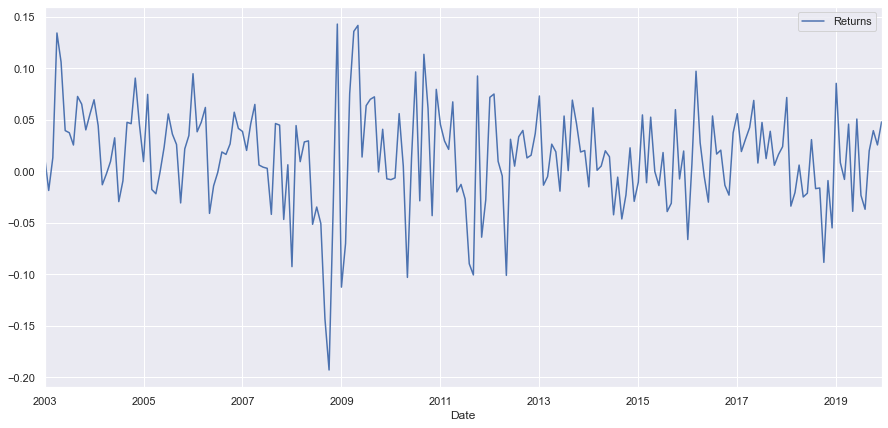

In [110]:
#retain only return data over time
ret_data = df_2[["ret", "id", "eom"]]
#create equal weights
ret_data["eq_weights"] = 1/ret_data.groupby('eom')["id"].transform('size')
#calculate montly return of the equally weighted portfolio contaning all stocks
ret_data['return_stock_ew'] = ret_data["ret"]*ret_data["eq_weights"]
ret_data['Returns'] = ret_data.groupby('eom')["return_stock_ew"].transform('sum')
#drop duplicates 
ret_data = ret_data[["eom", "Returns"]].drop_duplicates()
#rename eon (end of month) to "date"
ret_data = ret_data.rename(columns={'eom': 'Date'})
ret_data = ret_data.set_index("Date")
#plot the portfolio returns over time
ret_data.plot(grid=True,figsize=(15, 7));
#save grapgh
plt.savefig('portfolio monthly returns over time.png')

### Portfolio autocorrelation graph

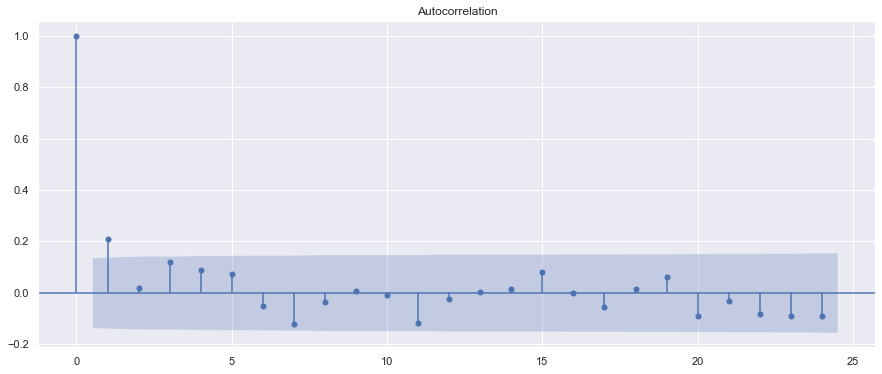

<Figure size 1080x432 with 0 Axes>

In [127]:
plot_acf(ret_data)
# Show the data as a plot (via matplotlib)
plt.show()
plt.savefig('Portfolio autocorrelation graph.png')

## Variable Correlation Heatmap

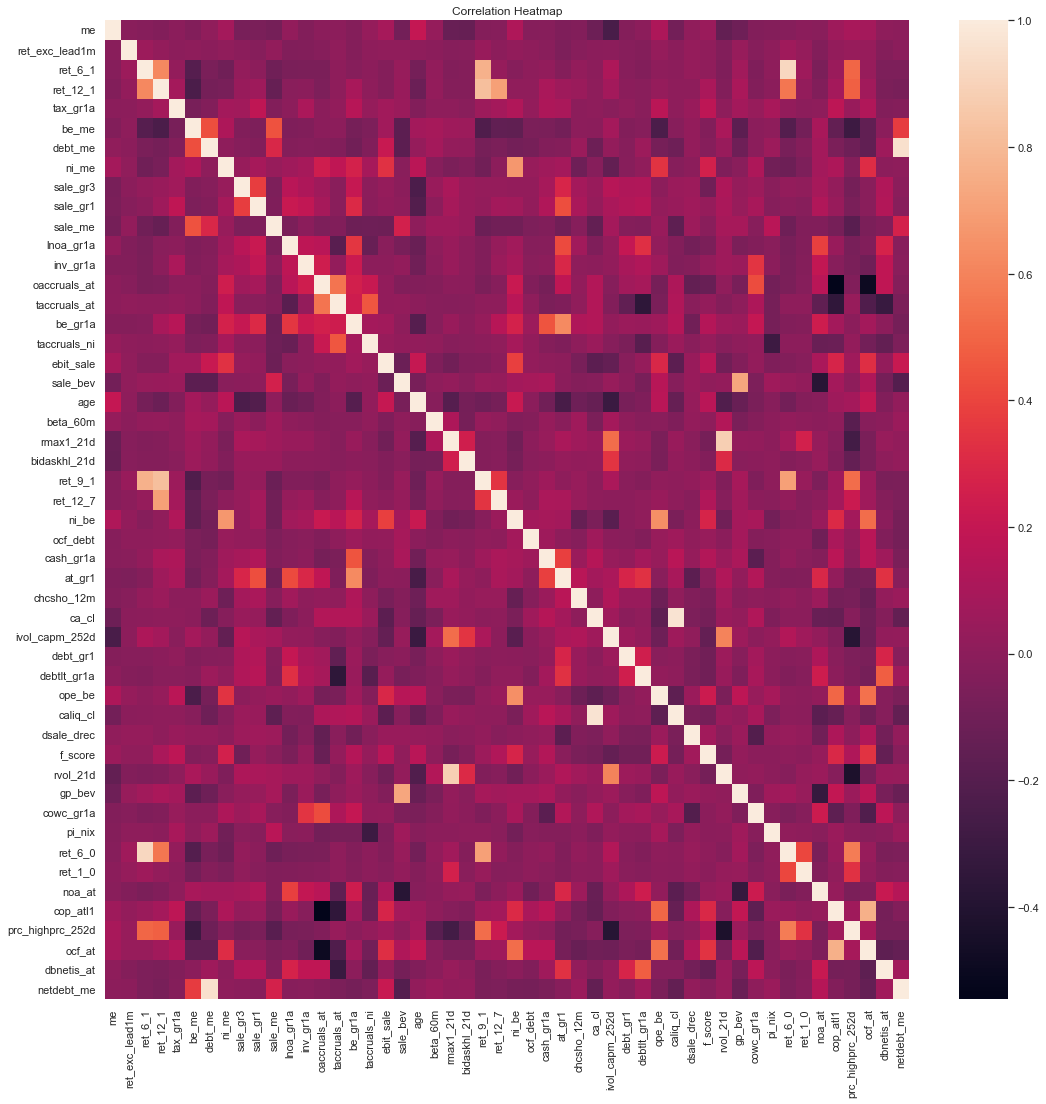

<Figure size 432x288 with 0 Axes>

In [17]:
features = df.columns[~df.columns.isin(['id',"prc","eom","ret","ret_exc"])].tolist()
plt.figure(figsize = (18,18))
sns.heatmap(data=df_2[features].corr())
plt.title('Correlation Heatmap')
plt.savefig('Correlation Heatmap.png')
plt.show()
plt.gcf().clear()

## Top Correlated Features (Pearson’s correlation)

In [21]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
c = df_2[features].corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort").reset_index()
so.columns = ['Variable 1','Variable 2', 'corr']
so = so.sort_values(by = ['corr', 'Variable 1'], ascending = False)
so = so[so['corr']!=1]
so = so.iloc[::2].reset_index(drop=True)
so

,Variable 1,Variable 2,corr
0,caliq_cl,ca_cl,0.969124
1,netdebt_me,debt_me,0.952986
2,ret_6_1,ret_6_0,0.916503
3,rvol_21d,rmax1_21d,0.880674
4,ret_9_1,ret_12_1,0.820910
5,ret_9_1,ret_6_1,0.769244
6,ocf_at,cop_atl1,0.759973
7,sale_bev,gp_bev,0.728095
8,ret_9_1,ret_6_0,0.703522
9,ret_12_7,ret_12_1,0.699054


In [23]:
so.to_excel(r'C:\Users\krist\Documents\Data\EDA\variable_correlation.xlsx')

## Correlation of the stock level characteristics with the target variable (ret_exc_lead1m)
    

In [12]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
correlation = df_2.corr()["ret_exc_lead1m"].abs().sort_values(ascending = False)
corr_df = pd.DataFrame(correlation)
corr_df

,ret_exc_lead1m
ret_exc_lead1m,1.000000
ret_6_0,0.064510
ret_6_1,0.056625
at_gr1,0.050701
ret_9_1,0.044715
lnoa_gr1a,0.038386
prc_highprc_252d,0.037993
ocf_at,0.036222
rvol_21d,0.035136
gp_bev,0.034841


In [33]:
corr_df.to_excel(r'C:\Users\krist\Documents\Data\EDA\target_correlation.xlsx')